# Test

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('aggregate_data_hourly.csv')
df1 = df['close']
df1

0        131351.241429
1        131329.062167
2        130994.521000
3        131081.648333
4        131375.910333
             ...      
12336    259652.233636
12337    258618.822500
12338    258738.966667
12339    260985.861111
12340    260725.736667
Name: close, Length: 12341, dtype: float64

In [3]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
training_size=int(len(df1)*0.8)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [5]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [8]:
X_train.shape[1]

100

In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(GRU(50, activation = 'relu', return_sequences = True,  input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(50, return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 50)           7950      
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 gru_1 (GRU)                 (None, 100, 50)           15300     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 38,601
Trainable params: 38,601
Non-traina

In [11]:
model.fit(X_train, y_train, epochs=20, batch_size=64, shuffle=False)

Epoch 1/20
153/153 [==============================] - 14s 75ms/step - loss: 0.0046
Epoch 2/20
153/153 [==============================] - 13s 88ms/step - loss: 0.0066
Epoch 3/20
153/153 [==============================] - 18s 117ms/step - loss: 0.0059
Epoch 4/20
153/153 [==============================] - 20s 128ms/step - loss: 0.0065
Epoch 5/20
153/153 [==============================] - 14s 89ms/step - loss: 0.0078
Epoch 6/20
153/153 [==============================] - 13s 88ms/step - loss: 0.0076
Epoch 7/20
153/153 [==============================] - 14s 90ms/step - loss: 0.0053
Epoch 8/20
153/153 [==============================] - 14s 90ms/step - loss: 0.0034
Epoch 9/20
153/153 [==============================] - 13s 88ms/step - loss: 0.0025
Epoch 10/20
153/153 [==============================] - 13s 88ms/step - loss: 0.0016
Epoch 11/20
153/153 [==============================] - 13s 86ms/step - loss: 0.0010
Epoch 12/20
153/153 [==============================] - 13s 87ms/step - loss: 5.8872

In [12]:
test_predict = model.predict(X_test)

74/74 [==============================] - 2s 19ms/step


In [13]:
print(f'MSE {mean_squared_error(y_test, test_predict)}')
print(f'R2 {r2_score(y_test, test_predict)}')

MSE 0.0084685573451235
R2 -0.5323080061168881


In [14]:
test_predict= scaler.inverse_transform(test_predict)
train_predict = model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)

306/306 [==============================] - 6s 18ms/step


In [15]:
look_back = 100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

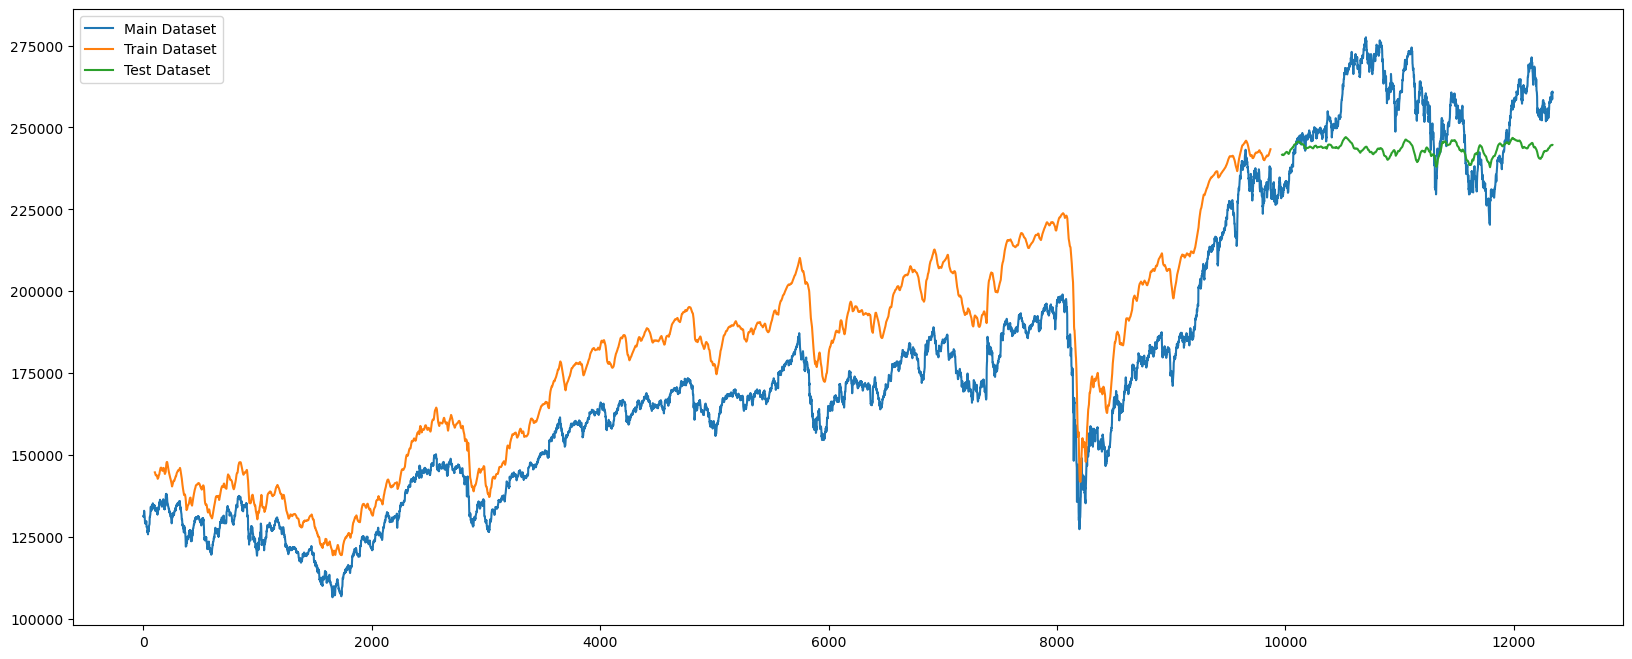

In [16]:
plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(df1), label = 'Main Dataset')
plt.plot(trainPredictPlot, label = 'Train Dataset')
plt.plot(testPredictPlot, label = 'Test Dataset')
plt.legend()